# Exercise 06 : Scatter Matrix

## Import

In [89]:
import pandas as pd
import sqlite3
from pandas.plotting import scatter_matrix

## Connect to database

In [90]:
db_connect = sqlite3.connect('../data/checking-logs.sqlite.sqlite')

In [91]:
a = db_connect.cursor().execute('SELECT name from sqlite_master where type= "table"')
print(a.fetchall())

[('pageviews',), ('checker',), ('deadlines',), ('datamart',), ('test',)]


## Get all commit datetimes from `checker` table

In [92]:
sql_query = """
SELECT
    uid,
    COUNT(timestamp) AS commits
FROM
    checker
WHERE
    checker.uid LIKE 'user_%'
    AND checker.labname != 'project1'
GROUP BY
    uid
"""

user_commits_count_df = pd.read_sql(sql=sql_query, con=db_connect, index_col='uid')
user_commits_count_df.head()

,commits
uid,
user_0,3
user_1,62
user_10,20
user_11,7
user_12,86


In [93]:
user_commits_count_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, user_0 to user_8
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   commits  30 non-null     int64
dtypes: int64(1)
memory usage: 480.0+ bytes


In [94]:
sql_query = """
SELECT
    uid,
    COUNT(datetime) AS pageviews
FROM
    pageviews
WHERE
    pageviews.uid LIKE 'user_%'
GROUP BY
    uid
"""

user_pageviews_count_df = pd.read_sql(sql=sql_query, con=db_connect, index_col='uid')
user_pageviews_count_df.head()

,pageviews
uid,
user_1,28
user_10,89
user_14,143
user_17,47
user_18,3


In [95]:
user_pageviews_count_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13 entries, user_1 to user_9
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   pageviews  13 non-null     int64
dtypes: int64(1)
memory usage: 208.0+ bytes


In [96]:
sql_query="""
CREATE TABLE datamart AS
    SELECT
        checker_data.uid,
        checker_data.labname,
        checker_data.first_commit_ts,
        pageviews_data.first_view_ts
    FROM
    (
        SELECT
            uid, labname, timestamp AS first_commit_ts
        FROM
            checker
        WHERE
            uid LIKE 'user_%'
            AND status = 'ready'
            AND numTrials = 1
            AND labname in ('laba04', 'laba04s', 'laba05', 'laba06', 'laba06s', 'project1')
    ) checker_data
    LEFT OUTER JOIN
    (
        SELECT
            uid, MIN(datetime) as first_view_ts
        FROM
            pageviews
        GROUP BY
            uid
    ) pageviews_data
    ON
        checker_data.uid = pageviews_data.uid
"""

db_connect.cursor().execute("DROP TABLE IF EXISTS datamart;")
db_connect.cursor().execute(sql_query)

In [97]:
sql_query = "SELECT * FROM datamart;"

datamart = pd.io.sql.read_sql(sql=sql_query, con=db_connect, parse_dates=['first_commit_ts', 'first_view_ts'])
test = datamart[datamart['first_view_ts'].notnull()]
test.to_sql('test', db_connect, if_exists='replace')

59

In [98]:
sql_query = """
SELECT uid,
       CAST((JulianDay(test.first_commit_ts) - JulianDay(DATETIME(deadlines.deadlines, 'unixepoch'))) * 24 AS Integer) AS delta
FROM
    test
LEFT JOIN
    deadlines ON test.labname=deadlines.labs
WHERE labname <> 'project1'
"""

delta = pd.read_sql(sql=sql_query, con=db_connect)
delta

,uid,delta
0,user_30,-202
1,user_30,-201
2,user_14,-200
3,user_14,-193
4,user_19,-148
5,user_25,-148
6,user_21,-126
7,user_21,-99
8,user_28,-98
9,user_17,-81


In [104]:
user_pageviews_count_df.reset_index(inplace=True)
user_commits_count_df.reset_index(inplace=True)

In [105]:
delta = delta.groupby(['uid']).mean()
pivot_table = user_pageviews_count_df.merge(user_commits_count_df, on=['uid'])
pivot_table = delta.merge(pivot_table, on=['uid'])
pivot_table = pivot_table.drop(columns = ['uid'])
pivot_table

,delta,pageviews,commits
0,-64.400000,28,62
1,-74.800000,89,20
2,-159.000000,143,61
3,-61.600000,47,51
4,-5.666667,3,5
5,-98.750000,16,118
6,-95.500000,10,65
7,-92.600000,179,79
8,-86.400000,149,60
9,-105.400000,317,18


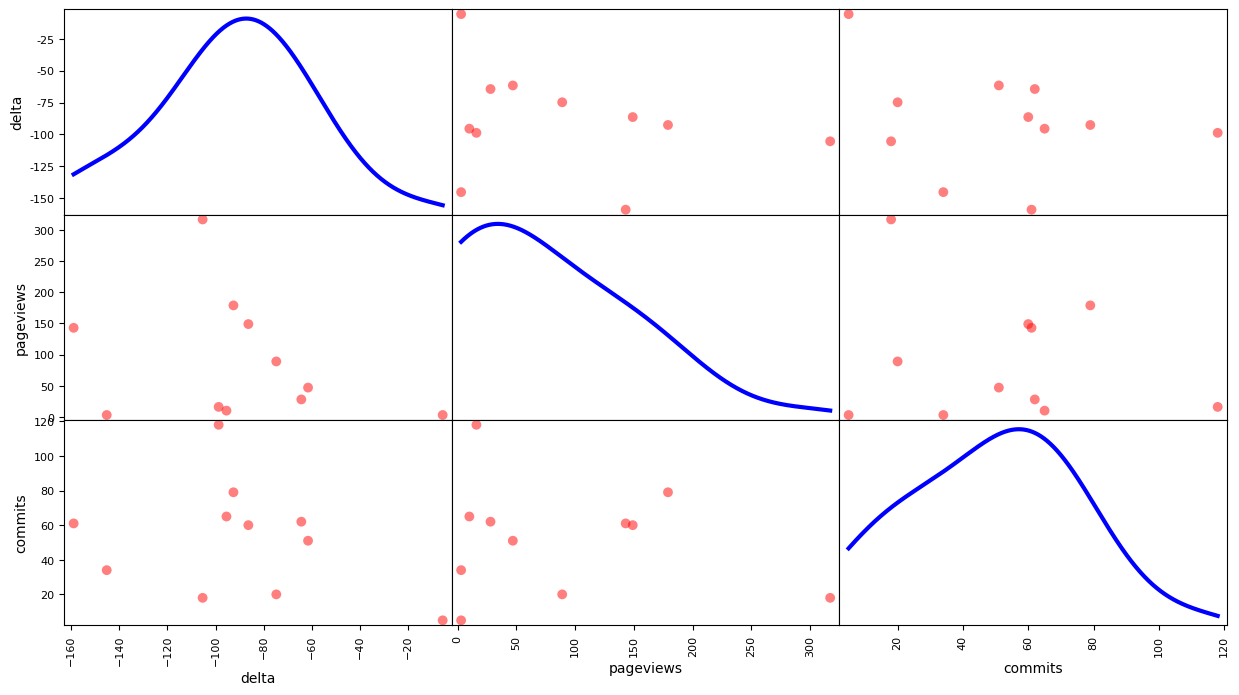

In [109]:
ax = scatter_matrix(pivot_table,figsize=(15, 8), diagonal='kde', density_kwds=dict(color='blue', linewidth=3), s=200, color='red')

## Close the connection to the database

In [110]:
db_connect.close()

## Can we say that if a user has a low number of pageviews then they likely have a low number of commits?
### No

## Can we say that if a user has a low number of pageviews then they likely have a small average difference between the first commit and the lab deadline?
### No

## Can we say that there are many users with a low number of commits and a few with a high number of commits?
### Yes

## Can we say that there are many users with a small average difference and a few with a large average difference?
### No